In this notebook, RNN estimator is used as a reference model.
This choice is leaded by the fact that :

<pre>
<li>NN model are non-linear models, then it is supposed to capture non-linear relations in between features </li>
<li>RNN model provides results more efficiently considering time criteria.</li>
</pre>

Multiple dataset are used in order to benchmark assumptions forged about model.  

GRU NN uses few parameters. 

    Then IBFGS may be used rather then SGD for descent algorithm.

In [8]:
%load_ext autoreload
%autoreload 2

In [2]:
import jyquickhelper
jyquickhelper.add_notebook_menu(first_level=1, last_level=4, header="RNN Regressor")

In [ ]:
import numpy as np
import time

import tensorflow as tf
import pandas as pd
import gensim

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import p8_util
import p8_util_config
import p9_util

import p5_util

extension='_part'



In [ ]:
OUTPUT_DIR = './tmp/baseline'
OUTPUT_DIR_TB = './tmp'
is_tensorboard = False

#### Tensorboard processes are killed

In [ ]:
# this will kill the processes for Tensorboard
#is_tensorboard = True
if is_tensorboard is True :
    !ps aux | grep tensorboard | awk '{print $2}' | xargs kill
# this will kill the processes for ngrok
if is_tensorboard is True :
    !ps aux | grep ngrok | awk '{print $2}' | xargs kill    

# <font color=blus>1. Loading dataset</font>

In [1]:
!ls -alrth ./data/*.dill

-rw-r--r-- 1 bangui bangui   87 sept.  2 15:30 ./data/test.dill
-rw-r--r-- 1 bangui bangui 615M sept.  2 18:21 ./data/DataPreparator_train_v2_spacy_15000.dill
-rw-r--r-- 1 bangui bangui 615M sept.  2 22:14 ./data/DataPreparator_valid_v2_spacy_15000.dill
-rw-r--r-- 1 bangui bangui 2,8G sept.  3 14:16 ./data/DataPreparator_valid_v2_spacy_notfidf_15000.dill
-rw-r--r-- 1 bangui bangui 2,8G sept.  3 15:34 ./data/DataPreparator_train_v2_spacy_notfidf_15000.dill
-rw-r--r-- 1 bangui bangui 401M sept.  4 00:25 ./data/X_y_train.dill
-rw-r--r-- 1 bangui bangui 198M sept.  4 00:26 ./data/X_y_valid.dill
-rw-r--r-- 1 bangui bangui 418M sept.  4 01:16 ./data/DataPreparator_train_v2_spacy_notfidf_1_20000.dill
-rw-r--r-- 1 bangui bangui 3,6G sept.  4 11:41 ./data/DataPreparator_train_v2_spacy_notfidf_2_20000.dill
-rw-r--r-- 1 bangui bangui 773M sept.  4 13:57 ./data/DataPreparator_train_v2_spacy_notfidf_20000.dill
-rw-r--r-- 1 bangui bangui 289M sept.  5 19:37 ./data/DataPreparator_v2_spacy_valid_10_st

## <font color=blus>1.0. Global process </font>

In [21]:
import p9_util_config
dir(p9_util_config)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'dict_param_generator',
 'dict_param_keras',
 'dict_param_keras_rnn']

    Build DataGenerator objects for Keras RNN architecture.

In [1]:
!rm ./data/train_X_*.*
!rm ./data/valid_X_*.*
import p9_util
import p9_util_config
import test_datapreparator

#----------------------------------------------------------------------------
# Common parameters for DataGenerator objects.
#----------------------------------------------------------------------------
dict_param_generator = p9_util_config.dict_param_generator
var_percent = 0.6
if True :
    #----------------------------------------------------------------------------
    # DataGenerator for train dataset
    #----------------------------------------------------------------------------
    dict_param_generator['partition_size'] = 1000
    dict_param_generator['batch_size'] = 500
    dict_param_generator['data_type'] = "train"
    dict_param_generator['is_dimension_mux'] = False

    dict_rnn_preprocess={
        'filename_datapreparator' : './data/DataPreparator_train_v2_spacy_notfidf_20000.dill',\
        'var_percent' : var_percent,\
    }
    train_generator = test_datapreparator.build_rnn_datagenerator(**dict_rnn_preprocess)

#----------------------------------------------------------------------------
# DataGenerator for validation dataset
#----------------------------------------------------------------------------
dict_param_generator['partition_size'] = 800
dict_param_generator['batch_size'] = 100
dict_param_generator['data_type'] = "valid"
dict_param_generator['is_dimension_mux'] = False

dict_rnn_preprocess={
    'filename_datapreparator' : './data/DataPreparator_v2_spacy_valid_1000.dill',\
    'var_percent' : var_percent,\
}
valid_generator = test_datapreparator.build_rnn_datagenerator(**dict_rnn_preprocess)

/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.
W0910 16:59:02.628354 140323774711616 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0910 16:59:02.628952 140323774711616 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W0910 16:5

p5_util.object_load : fileName= ./data/DataPreparator_train_v2_spacy_notfidf_20000.dill

DataPreparator Dataframe shape= (17366, 5)

Components= 34 for variance= 60.0%

data_type : train
partition_size : 1000
is_dimension_mux : False
proj_dimension : 0
batch_size : 500
n_classes : 0
n_channels : 0
is_shuffle : False
keras_nb_channel : 34
keras_input_dim : (80, 1)
Building train partition...

p5_util.object_load : fileName= ./data/DataPreparator_v2_spacy_valid_1000.dill

DataPreparator Dataframe shape= (860, 5)

Components= 34 for variance= 60.0%

data_type : valid
partition_size : 800
is_dimension_mux : False
proj_dimension : 0
batch_size : 100
n_classes : 0
n_channels : 0
is_shuffle : False
keras_nb_channel : 34
keras_input_dim : (80, 1)
Building valid partition...



In [2]:
!ls -alrth ./data/valid_*.npy

-rw-r--r-- 1 bangui bangui  17M sept. 10 16:59 ./data/valid_X_0.npy
-rw-r--r-- 1 bangui bangui 1,3M sept. 10 16:59 ./data/valid_X_1.npy


In [13]:
import p9_util
import p9_util_keras
import p9_util_config


lstm_out    = p9_util_config.dict_param_keras_rnn['lstm_out']
cell_units  = p9_util_config.dict_param_keras_rnn['cell_units']
rnn_layers  = p9_util_config.dict_param_keras_rnn['rnn_layers']
rnnCellType = p9_util_config.dict_param_keras_rnn['rnnCellType']
dict_param_keras = p9_util_config.dict_param_keras_rnn['dict_param_keras']
is_batch_normalized = dict_param_keras['is_batch_normalized']
dropout_rate = dict_param_keras['dropout_rate']

lr = dict_param_keras['lr']


input_shape = train_generator.get_params()['keras_input_dim']

model = p9_util_keras.keras_rnn_build(\
                                        rnnCellType, \
                                        cell_units, \
                                        input_shape, \
                                        isWordEmbedding=False,\
                                        nbClasses=1,
                                        rnn_layers=rnn_layers,\
                                        is_batch_normalized= is_batch_normalized,\
                                          dropout_rate=dropout_rate,\
                                        lr = lr)
for key, value in p9_util_config.dict_param_keras_rnn.items() :
    print("{} : {}".format(key, value))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_13 (GRU)                 (None, 80, 8)             240       
_________________________________________________________________
batch_normalization_13 (Batc (None, 80, 8)             32        
_________________________________________________________________
gru_14 (GRU)                 (None, 80, 8)             408       
_________________________________________________________________
batch_normalization_14 (Batc (None, 80, 8)             32        
_________________________________________________________________
gru_15 (GRU)                 (None, 8)                 408       
_________________________________________________________________
batch_normalization_15 (Batc (None, 8)                 32        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total para

In [15]:
import p9_util_keras
import p9_util_config


nb_epoch = p9_util_config.dict_param_keras['nb_epoch']

# Train model on dataset

history = model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    use_multiprocessing=False,
                    workers=1, verbose=1, epochs=nb_epoch)

Epoch 1/15
35/35 [==============================] - 13s 358ms/step - loss: 0.0421 - mean_absolute_error: 0.1507 - val_loss: 0.0406 - val_mean_absolute_error: 0.1694
Epoch 2/15
35/35 [==============================] - 12s 354ms/step - loss: 0.0420 - mean_absolute_error: 0.1516 - val_loss: 0.0358 - val_mean_absolute_error: 0.1514
Epoch 3/15
35/35 [==============================] - 11s 319ms/step - loss: 0.0420 - mean_absolute_error: 0.1513 - val_loss: 0.0351 - val_mean_absolute_error: 0.1477
Epoch 4/15
35/35 [==============================] - 24s 699ms/step - loss: 0.0419 - mean_absolute_error: 0.1514 - val_loss: 0.0351 - val_mean_absolute_error: 0.1474
Epoch 5/15
35/35 [==============================] - 35s 987ms/step - loss: 0.0418 - mean_absolute_error: 0.1513 - val_loss: 0.0345 - val_mean_absolute_error: 0.1431
Epoch 6/15
35/35 [==============================] - 31s 878ms/step - loss: 0.0417 - mean_absolute_error: 0.1508 - val_loss: 0.0340 - val_mean_absolute_error: 0.1365
Epoch 7/15

In [ ]:
import p9_util_config

batch_size = p9_util_config.dict_keras_rnn['batch_size']
nb_epoch = p9_util_config.dict_keras_rnn['nb_epoch']
verbose = p9_util_config.dict_keras_rnn['verbose']


history = model.fit(x_train_reshape, \
                    y_train,\
                    validation_data=(x_valid_reshape,y_valid), \
                    batch_size =batch_size, \
                    nb_epoch = nb_epoch,\
                    verbose = verbose\
                    )

/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]
W0909 18:29:54.299860 140293607118656 deprecation.py:323] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0909 18:29:56.017870 140293607118656 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0909 18:29:56.073589 140293607118656 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_ba

Train on 17366 samples, validate on 860 samples
Epoch 1/50
17366/17366 [==============================] - 27s 2ms/step - loss: 0.0507 - mean_absolute_error: 0.1079 - val_loss: 0.0412 - val_mean_absolute_error: 0.0950
Epoch 2/50
17366/17366 [==============================] - 19s 1ms/step - loss: 0.0493 - mean_absolute_error: 0.1104 - val_loss: 0.0394 - val_mean_absolute_error: 0.0994
Epoch 3/50
10000/17366 [================>.............] - ETA: 11s - loss: 0.0461 - mean_absolute_error: 0.1119

In [ ]:
import keras

import p5_util

import p9_util_config

rnn_layers = p9_util_config.dict_keras_rnn['rnn_layers']
lstm_out = p9_util_config.dict_keras_rnn['lstm_out']
cell_units = p9_util_config.dict_keras_rnn['cell_units']
rnnCellType = p9_util_config.dict_keras_rnn['rnnCellType']

core_name = "gru_"+str(rnn_layers)+"layers_"+str(cell_units)+'units'

if True:
    model.save("./data/model_"+core_name+".h5")
    p5_util.object_dump(history, "history_"+core_name+".dump")
    #p5_util.object_dump(max_length, "max_length_"+core_name+".dump")
    
else :
    model = keras.models.load_model("./data/model_"+core_name+".h5")
    history = p5_util.object_load("history_"+core_name+".dump")
    #max_length = p5_util.object_load("max_length_"+core_name+".dump")

#print("\nInput data length= {}".format(max_length))
model.summary()

In [ ]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)

## <font color=blus>1.1. Loading `DataPreparator`</font>

In [18]:
!ls -alrth ./data/DataPreparator*.dump

-rw-r--r-- 1 bangui bangui 133M août  19 20:44 ./data/DataPreparator_train.dump
-rw-r--r-- 1 bangui bangui 134M août  19 20:44 ./data/DataPreparator_test.dump
-rw-r--r-- 1 bangui bangui 137M août  23 00:43 ./data/DataPreparator_train_spacy_20000.dump
-rw-r--r-- 1 bangui bangui 137M août  23 01:35 ./data/DataPreparator_test_spacy_20000.dump
-rw-r--r-- 1 bangui bangui 339M août  26 22:57 ./data/DataPreparator_train_spacy_15000.dump
-rw-r--r-- 1 bangui bangui 339M août  26 23:32 ./data/DataPreparator_test_spacy_15000.dump


In [5]:
import p5_util

filename = './data/DataPreparator_train_v2_spacy_notfidf_20000.dill'
dataPreparator_v2_train = p5_util.object_load(filename)

p5_util.object_load : fileName= ./data/DataPreparator_train_v2_spacy_notfidf_20000.dill


W0909 17:19:45.710314 140684464133952 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0909 17:19:45.710967 140684464133952 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W0909 17:19:45.721975 140684464133952 deprecation_wrapper.py:119] From /home/bangui/Dropbox/Perso/Formation/openclassrooms/OC_Datascientist/Kaggle/p8_util_config.py:137: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



In [6]:
import p5_util

filename = './data/DataPreparator_v2_spacy_valid_1000.dill'
dataPreparator_v2_valid = p5_util.object_load(filename)

p5_util.object_load : fileName= ./data/DataPreparator_v2_spacy_valid_1000.dill


## <font color=blus>1.2. Building train and test `DataGenerator` </font>

    Get the number fo components given an expected variance.

In [7]:
import p3_util_plot
pca = dataPreparator_v2_train.xpca
var_percent = 0.6
nb_component = p3_util_plot.get_component_from_cum_variance(pca, var_percent) 
#proj_dimension = nb_component-1
print("\nComponents= {} for variance= {}%".format(nb_component, var_percent*100))


Components= 34 for variance= 60.0%


In [8]:
embedding_dim=1
dimension = 0# Will be updated in function build_generators()
dict_param = {'dim': (dimension,embedding_dim),
              'batch_size': 100,
              'n_classes': 0,
              'n_channels': 0,
              'shuffle': False,
              'nb_channel':nb_component,
              #'is_matrix':False,
             }
partition_size = 1000
print(dict_param)

{'dim': (0, 1), 'batch_size': 100, 'n_classes': 0, 'n_channels': 0, 'shuffle': False, 'nb_channel': 34}


In [9]:
!rm ./data/train_X_*.*
!rm ./data/valid_X_*.*

import test_datapreparator

nb_channel = nb_component
input_dim = dataPreparator_v2_train.max_length
dict_param = {'dim': (input_dim,0),
              'batch_size': 100,
              'n_classes': 0,
              'n_channels': 0,
              'nb_channel': nb_channel,
              'shuffle': False,
              'is_mux' : True
}
print("")
for key, value in dict_param.items() :
    print("{} : {}".format(key,value))


partition_size = 1000
train_generator = test_datapreparator.build_generator(dataPreparator_v2_train, \
                     partition_size,\
                     dict_param,\
                     data_column_name='matrix_padded_truncated',\
                     data_type='train')


dim : (80, 0)
batch_size : 100
n_classes : 0
n_channels : 0
nb_channel : 34
shuffle : False
is_mux : True
Building train partition...



In [10]:
nb_channel = nb_component
input_dim = dataPreparator_v2_valid.max_length
dict_param = {'dim': (input_dim,0),
              'batch_size': 100,
              'n_classes': 0,
              'n_channels': 0,
              'nb_channel': nb_channel,
              'shuffle': False,
              'is_mux' : True
}
print("")
for key, value in dict_param.items() :
    print("{} : {}".format(key,value))

import test_datapreparator

partition_size = 100
valid_generator = test_datapreparator.build_generator(dataPreparator_v2_valid, \
                     partition_size,\
                     dict_param,\
                     data_column_name='matrix_padded_truncated',\
                     data_type='valid')


dim : (80, 0)
batch_size : 100
n_classes : 0
n_channels : 0
nb_channel : 34
shuffle : False
is_mux : True
Building valid partition...



    Get X and y for train and validation dataset samples, both projected over the given dimension.

In [13]:
dataPreparator_v2_train.X.shape

(17366, 300)

In [14]:
proj_dimension = nb_component-1

x_train_proj , y_train = train_generator.get_Xproj_y_from_generator(proj_dimension)
print("Train dataset shapes :      {}".format((x_train_proj.shape, y_train.shape)))

x_valid_proj , y_valid = valid_generator.get_Xproj_y_from_generator(proj_dimension)

print("Validation dataset shapes : {}".format((x_valid_proj.shape, y_valid.shape)))

y_train_label_vect_bin = dataPreparator_v2_train.vectorValue2BinaryvectorLabel(vector_value=y_train)
y_valid_label_vect_bin = dataPreparator_v2_valid.vectorValue2BinaryvectorLabel(vector_value=y_valid)

Train dataset shapes :      ((17366, 80), (17366,))
Validation dataset shapes : ((860, 80), (860,))


/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can

# <font color=blus>2. Modeling with RNN</font>

## <font color=blus>2.1. Modeling a regression with GRU</font>

In [4]:
import p9_util
import p9_util_keras
import p9_util_config


lstm_out = p9_util_config.dict_keras_rnn['lstm_out']
cell_units = p9_util_config.dict_keras_rnn['cell_units']
rnn_layers = p9_util_config.dict_keras_rnn['rnn_layers']
rnnCellType = p9_util_config.dict_keras_rnn['rnnCellType']
is_batch_normalized = p9_util_config.dict_keras_rnn['is_batch_normalized']


input_shape = (x_train_proj.shape[1],1)

model = p9_util_keras.keras_rnn_build(rnnCellType, \
                                cell_units, \
                                input_shape, \
                                isWordEmbedding=False,\
                                nbClasses=1,
                                rnn_layers=rnn_layers,\
                                is_batch_normalized= is_batch_normalized)

W0909 17:41:46.785356 140294232332096 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 17:41:46.788949 140294232332096 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 17:41:46.791442 140294232332096 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 17:41:47.116642 140294232332096 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 80, 64)            12672     
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 64)            256       
_________________________________________________________________
gru_2 (GRU)                  (None, 80, 64)            24768     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 64)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 80, 64)            256       
_________________________________________________________________
gru_3 (GRU)                  (None, 80, 64)            24768     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 64)            0         
__________

In [16]:
import numpy as np

#x_train_reshape = p9_util.keras_rnn_reshape(x_train_proj)
#x_valid_reshape = p9_util.keras_rnn_reshape(x_valid_proj)
x_train_reshape = np.reshape(x_train_proj, (x_train_proj.shape[0], x_train_proj.shape[1], 1))
x_valid_reshape = np.reshape(x_valid_proj, (x_valid_proj.shape[0], x_valid_proj.shape[1], 1))


In [5]:

batch_size = p9_util_config.dict_keras_rnn['batch_size']
nb_epoch = p9_util_config.dict_keras_rnn['nb_epoch']
verbose = p9_util_config.dict_keras_rnn['verbose']


history = model.fit(x_train_reshape, \
                    y_train,\
                    validation_data=(x_valid_reshape,y_valid), \
                    batch_size =batch_size, \
                    nb_epoch = nb_epoch,\
                    verbose = verbose)

NameError: name 'x_train_reshape' is not defined

In [10]:
# Train model on dataset
history = model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    use_multiprocessing=False,
                    workers=1, verbose=1, epochs=5)

W0909 19:14:15.583679 140189372000064 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0909 19:14:15.643103 140189372000064 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/5
174/174 [==============================] - 118s 676ms/step - loss: 0.0407 - mean_absolute_error: 0.1446 - val_loss: 0.0336 - val_mean_absolute_error: 0.1391
Epoch 2/5
174/174 [==============================] - 101s 580ms/step - loss: 0.0394 - mean_absolute_error: 0.1472 - val_loss: 0.0337 - val_mean_absolute_error: 0.1408
Epoch 3/5
174/174 [==============================] - 96s 555ms/step - loss: 0.0394 - mean_absolute_error: 0.1473 - val_loss: 0.0336 - val_mean_absolute_error: 0.1381
Epoch 4/5
174/174 [==============================] - 100s 574ms/step - loss: 0.0394 - mean_absolute_error: 0.1474 - val_loss: 0.0337 - val_mean_absolute_error: 0.1393
Epoch 5/5
174/174 [==============================] - 99s 572ms/step - loss: 0.0394 - mean_absolute_error: 0.1472 - val_loss: 0.0336 - val_mean_absolute_error: 0.1384


#### Reshape arrays for time series

    Arrays are shapes as [obervations, features].

    They are reshaped in order to feed RNN model with one observation to each step.
    
    Then reshaped will lead to [observations, 1, features]



In [52]:
batch_size = X_train_matrix.shape[0]//10
batch_size

500

In [53]:
history = model.fit(X_train_matrix, y_train,validation_data=(X_valid_matrix,y_valid), batch_size =batch_size, nb_epoch = 10,  verbose = 1)

/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 5000 samples, validate on 1000 samples
Epoch 1/10
5000/5000 [==============================] - 17s 3ms/step - loss: 0.0498 - mean_absolute_error: 0.1144 - val_loss: 0.0438 - val_mean_absolute_error: 0.1187
Epoch 2/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0428 - mean_absolute_error: 0.1330 - val_loss: 0.0399 - val_mean_absolute_error: 0.1407
Epoch 3/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0406 - mean_absolute_error: 0.1485 - val_loss: 0.0401 - val_mean_absolute_error: 0.1528
Epoch 4/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0407 - mean_absolute_error: 0.1547 - val_loss: 0.0403 - val_mean_absolute_error: 0.1544
Epoch 5/10
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0406 - mean_absolute_error: 0.1539 - val_loss: 0.0401 - val_mean_absolute_error: 0.1516
Epoch 6/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0405 - mean_absolute_error: 0.1509 - v

In [ ]:
X_train_matrix_reshape = np.reshape(X_train_matrix, (X_train_matrix.shape[0], 1, X_train_matrix.shape[1]))
#X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train_matrix_reshape.shape)
#print(X_test_reshape.shape)

In [ ]:
X_train_matrix[0].shape

In [ ]:
import numpy as np

X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train_reshape.shape)
print(X_test_reshape.shape)

    Fixe RNN hyper-parameters

In [ ]:
history = model.fit(X_train_reshape, y_train, batch_size =batch_size, nb_epoch = 30
                    ,validation_data=(X_test_reshape,y_test),  verbose = 1)

In [6]:
import p9_util_config
p9_util_config.dict_keras_rnn

{'lstm_out': 1, 'cell_units': 32, 'rnn_layers': 4, 'rnnCellType': 'GRU'}

In [1]:
import keras

import p5_util

import p9_util_config

rnn_layers = p9_util_config.dict_keras_rnn['rnn_layers']
lstm_out = p9_util_config.dict_keras_rnn['lstm_out']
cell_units = p9_util_config.dict_keras_rnn['cell_units']
rnnCellType = p9_util_config.dict_keras_rnn['rnnCellType']

core_name = "gru_"+str(rnn_layers)+"layers_"+str(cell_units)+'units'

if True:
    model.save("./data/model_"+core_name+".h5")
    p5_util.object_dump(history, "history_"+core_name+".dump")
    #p5_util.object_dump(max_length, "max_length_"+core_name+".dump")
    
else :
    model = keras.models.load_model("./data/model_"+core_name+".h5")
    history = p5_util.object_load("history_"+core_name+".dump")
    #max_length = p5_util.object_load("max_length_"+core_name+".dump")

#print("\nInput data length= {}".format(max_length))
model.summary()

Using TensorFlow backend.


NameError: name 'model' is not defined

#### <font color=blus>Computation of classifications performances</font>

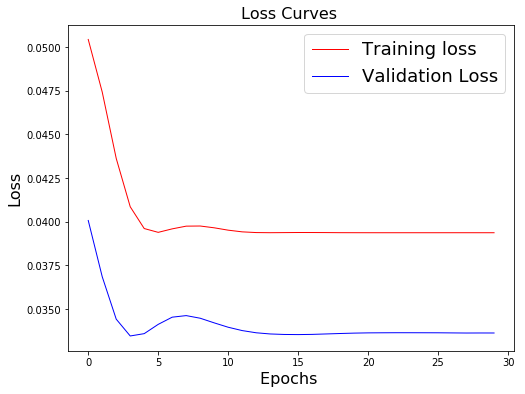

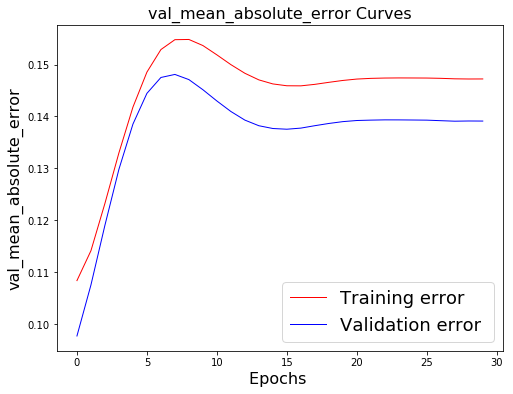

In [3]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)

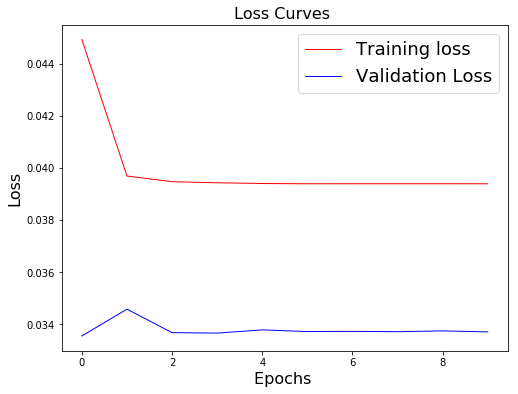

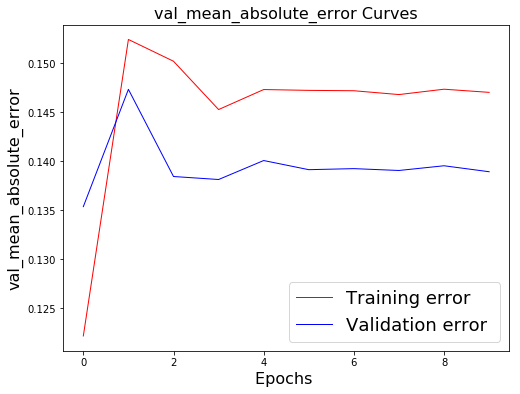

In [9]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)

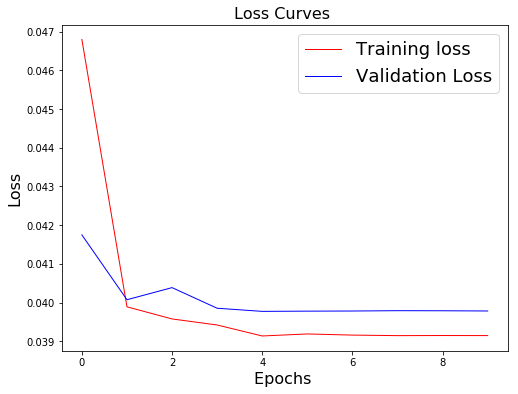

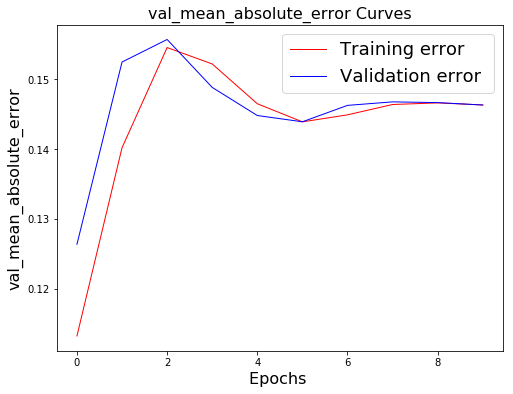

In [5]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)

## <font color=blus>2.1 Switch to classification problem</font>

    Targets, that are coninues values from float type, are converted into classes of integers, such leading to a classification model.
    
    For doing that, y_train_encoded and y_test_encoded are transformed as array of integers, 
    ranging from 0 to 10, leading to 11 classes.

### <font color=blus>2.1.1 Binary classification</font>

Target is splitted based 

`y_train_label` and `y_test_label` are arrays with number of columns as number of classes.

Classes are one-hot-encoded for each observation.

In [ ]:
y_train.min(), y_train.max()
np.round(y_train*1.0, 1).astype(int)

`y_train` and `y_test` are vectors with float values ranging from `0.0` to `1.0`. 

`y_train_label` and `y_test_label` are matrix issued from One-hot-encoding were position of 1 value in a column indicates the class value.

`decimal_count` is the value allowing to take into account the number of decimals when converting continuous values into classes.

In [ ]:
import p9_util
decimal_count=1
nb_classes, y_train_label = p9_util.y_reg_2_label(y_train, decimal_count=decimal_count)
_, y_test_label = p9_util.y_reg_2_label(y_test, decimal_count=decimal_count)

print("\nNumber of classes= {}".format(nb_classes))

`y_train_label_vect` and `y_test_label_vect` are vectors issues from `[N x Classes]` matrix, where `N` is the 
number of samples and `Classes` the number of classes.

After this target conversion, unique column values are classes number, ranged from `0` to `10`.

In [ ]:
import p9_util

y_train_label_vect = np.array([p9_util.get_label_from_row(y_train_label[row]) for row in range(0,len(y_train_label))])
y_test_label_vect  = np.array([p9_util.get_label_from_row(y_test_label[row])  for row in range(0,len(y_test_label))])

`Counter` class from `collection` package is used in order to compute occurencies fo each class in the data-model.

In [ ]:
from collections import Counter

counter_y_train_label_vect = Counter(y_train_label_vect)
counter_y_test_label_vect  = Counter(y_test_label_vect)

print(counter_y_train_label_vect, counter_y_train_label_vect[0]+counter_y_train_label_vect[1])
print(counter_y_test_label_vect, counter_y_test_label_vect[0]+counter_y_test_label_vect[1])

    Diagram below shows classes distribution for train (blue) and test (orange) dataset.

    Both diagrams shows same shape.

In [ ]:
fig = plt.figure(figsize=(5,5))
_=sns.kdeplot(y_train_label_vect, shade=True)
_=sns.kdeplot(y_test_label_vect, shade=True)
fig.legend(labels=['Train classes distribution','Test classes distribution'])
plt.show()

In [ ]:
threshold = 0
direction = 1
y_train_label_bin = multivalue2_binary(y_train_label_vect, threshold, direction)
y_test_label_bin = multivalue2_binary(y_test_label_vect, threshold, direction)

In [ ]:
from collections import Counter
counter_y_train_label_bin = Counter(y_train_label_bin)
counter_y_test_label_bin  = Counter(y_test_label_bin)

print(counter_y_train_label_bin, counter_y_train_label_bin[0]+counter_y_train_label_bin[1])
print(counter_y_test_label_bin, counter_y_test_label_bin[0]+counter_y_test_label_bin[1])

    Split target vector to balance train and test categories.

In [ ]:
split_number = len(y_test_label_bin)
split_number
X_train_split = X_train[:split_number]
y_train_label_bin_split = y_train_label_bin[:split_number]
X_train_split.shape, X_test.shape

In [ ]:
fig = plt.figure(figsize=(5,5))
_=sns.kdeplot(y_train_label_bin_split, shade=True)
_=sns.kdeplot(y_test_label_bin, shade=True)
fig.legend(labels=['Train classes distribution','Test classes distribution'])
plt.show()

#### <font color='blus'>Appying RNN model to binary classification</font>

    Dataset are reshaped inorder to feed Keras RNN.

In [ ]:
import p9_util

X_train_reshape = p9_util.keras_rnn_reshape(X_train_split)
X_test_reshape = p9_util.keras_rnn_reshape(X_test)

For feeding RNN network, `y_train_label_bin_split` and `y_test_label_bin` are converted into matrix where 
number of columns is the number of classes.

In [ ]:
nb_classes, y_train_label_bin_split = p9_util.y_reg_2_label(y_train_label_bin_split, decimal_count=0)
_, y_test_label_bin = p9_util.y_reg_2_label(y_test_label_bin, decimal_count=0)
print(y_train_label_bin_split.shape)
print(y_test_label_bin.shape)


#### <font color=blus>Building GRU model with 1 layer </font>

In [ ]:
lstm_out = 1
cell_units = 16*2
rnn_layers = 1
batch_size = X_train_split.shape[0]//10

import p9_util

rnnCellType = 'GRU'

model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, rnn_layers=rnn_layers)

In [ ]:
history = model.fit(X_train_reshape, y_train_label_bin_split, batch_size =batch_size, nb_epoch = 10
                    ,validation_data=(X_test_reshape,y_test_label_bin),  verbose = 1)

#### <font color=blus>Computation of classifications performances</font>

In [ ]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

In [ ]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label_bin, is_binary=True, y_pred=None)

#### <font color=blus>Building GRU model with 2 layers </font>

In [ ]:
lstm_out = 1
cell_units = 16*2
rnn_layers = 2
batch_size = X_train_split.shape[0]//10

import p9_util

rnnCellType = 'GRU'

model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, rnn_layers=rnn_layers)

In [ ]:
history = model.fit(X_train_reshape, y_train_label_bin_split, batch_size =batch_size, nb_epoch = 10
                    ,validation_data=(X_test_reshape,y_test_label_bin),  verbose = 1)

#### <font color=blus>Computation of classifications performances</font>

In [ ]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

In [ ]:
import p9_util
toxicity_threshold = 0.5
y_train_label = np.where(y_train <= toxicity_threshold, 0, 1)
y_test_label  = np.where(y_test  <= toxicity_threshold, 0, 1)

nb_classes, y_train_label = p9_util.y_reg_2_label(y_train_label)
_, y_test_label = p9_util.y_reg_2_label(y_test_label)


nb_classes = y_train_label.shape[1]
print("\nNumber of classes issued from one hot encoding= {}".format(nb_classes))

In [ ]:
nb_classes = 2
cell_units, max_length,nb_classes

In [ ]:
import p9_util

rnnCellType = 'GRU'

model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes)

In [ ]:
history = model.fit(X_train_reshape, y_train_label, batch_size =batch_size, nb_epoch = 60
                    ,validation_data=(X_test_reshape,y_test_label),  verbose = 1)

#### <font color=blus>Computation of classifications performances</font>

In [ ]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

    It can be seen that, even if cost function may continue to decrease, then
    accuracy will not improve.
    This is due to influence of a great number of observations that are toxicity free, considering 
    others observations.

    Toxicity predictions classes are firstly computed from test dataset issued from texts to be tested.
    Target test vector, a [Nx11] matrix, is transformed into a vector of N rows.
    For achieving this, function 
`p9_util.get_label_from_row()` 

    is used for any row from matrix.
    This allows to compute confusion matrix then plot it.

In [ ]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label, is_binary=True, y_pred=y_)

#### <font color='blus'> Use of Adagrad optimizer for binary classification</font>

In [ ]:
import p9_util

rnnCellType = 'GRU'

model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, optimizer_name='Adagrad')

In [ ]:
history = model.fit(X_train_reshape, y_train_label, batch_size =batch_size, nb_epoch = 60
                    ,validation_data=(X_test_reshape,y_test_label),  verbose = 1)

#### <font color=blus>Computation of binary classifications performances</font>

In [ ]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Binary classification')

    Here under, distributions of computed predictions are calculated.

In [ ]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label, is_binary=True, y_pred=None)

### <font color=blus>2.1.2 Multi-label classification</font>

    Classes are created based on range values for toxicity, as following :
        * From 0.0 <= toxicity <= 0.1 class is 0
        * From 0.1 < toxicity  <= 0.2 class is 1
                    ...
        * From 0.9 < toxicity  <= 1.0 class is 10
    
    Leading to 11 classes

In [ ]:
# This is for avoiding to compute prediction again, once already done, in the performance evaluation step function.
y_=None

In [ ]:
import p9_util

nb_classes, y_train_label = p9_util.y_reg_2_label(y_train)
_, y_test_label = p9_util.y_reg_2_label(y_test)
print("\nNumber of classes issued from one hot encoding= {}".format(nb_classes))

In [ ]:
rnnCellType = 'GRU'
cell_units = 16*2
lstm_out = 1
rnn_layers = 2

In [ ]:
import p9_util

max_length = len(X_train[0])
print("\nInput length= {}".format(max_length))
print("Number of units per RNN cell= {}".format(cell_units))

model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes, optimizer_name='Adagrad')

In [ ]:
batch_size = X_train.shape[0]//10

# This is the size of vector words.
embedding_dim = 100
vocab_size = len(keras_tokenizer.word_index) + 1
print("Vocabulary size= {}".format(vocab_size))
print("Batch size= {}".format(batch_size))
print("Embeddings dimension= {}".format(embedding_dim))


In [ ]:
import numpy as np

X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train_reshape.shape)
print(X_test_reshape.shape)

In [ ]:
history = model.fit(X_train_reshape, y_train_label, batch_size =batch_size, nb_epoch = 30
                    ,validation_data=(X_test_reshape,y_test_label),  verbose = 1)

In [ ]:
import keras
import p5_util
core_name = "gru_"+str(rnn_layers)+"layers_"+str(cell_units)+'units_class'

if False :
    model.save("./data/model_"+core_name+".h5")
    p5_util.object_dump(history, "history_"+core_name+".dump")
    p5_util.object_dump(max_length, "max_length_"+core_name+".dump")
    
else :
    model = keras.models.load_model("./data/model_"+core_name+".h5")
    history = p5_util.object_load("history_"+core_name+".dump")
    max_length = p5_util.object_load("max_length_"+core_name+".dump")

print("\nInput data length= {}".format(max_length))
model.summary()

#### <font color=blus>Computation of classifications performances</font>

In [ ]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='Multi-label classification')

    Those curves shows impact from Adagrad compared to SGD.
    
    Adagrad penalize features that are frequently updated and encourage features not frequently updated to 
    learn more, mean, to be updated more frequently.
    
    By learning more, it is expected that sparse features to contribute more to cost function decrease.
    
    This is what curves inference. Decrease of loss function is not driven by free toxicity text only!
    
    For avoiding overfitting, it would be relevant to apply dropout over cells.
    
    Considering training performance model, overfitting reduction is not yet is the agenda.

    Targets vector, [Nx11] matrix, is transformed into a vector of N rows.
    For achieving this, function 
`p9_util.get_label_from_row` 
    
    is used for any row from matrix.
    This allows to compute confusion matrix then plot it.

In [ ]:
import p9_util
y_= p9_util.display_class_performance(model, X_test_reshape, y_test_label, is_binary=False, y_pred=y_)

### <font color=blus>2.1.3. Overfiting study : LinearSVC</font>

    Turn float values from target vectors into classes

In [ ]:
import p9_util

nb_classes, y_train_label = p9_util.y_reg_2_label(y_train)
_, y_test_label = p9_util.y_reg_2_label(y_test)
print("\nNumber of classes issued from one hot encoding= {}".format(nb_classes))

    Turn target values shaped as a matrix [N,11] into vector of dimension N.
    11 above is the number of classes.

In [ ]:
import p9_util

#--------------------------------------------------------------
# Use of function get_label_from_row
#--------------------------------------------------------------
y_train_label_row = [p9_util.get_label_from_row(y_train_label[row], indicator=1) for row in range(0,len(y_train_label))]
y_test_label_row  = [p9_util.get_label_from_row(y_test_label[row], indicator=1) for row in range(0,len(y_test_label))]

y_train_label_row = np.array(y_train_label_row)
y_test_label_row = np.array(y_test_label_row)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#-----------------------------------------------------------------
# Display prediction classes ditribution
#-----------------------------------------------------------------
fig = plt.figure(figsize=(5,5))
_=sns.kdeplot(y_train_label_row, shade=True)
_=sns.kdeplot(y_test_label_row, shade=True)
fig.legend(labels=['Train classes distribution','Test classes distribution'])
plt.show()

    Train and test distributions have same shape

In [ ]:
from sklearn import svm
model = svm.LinearSVC()
X_train.shape

In [ ]:
model = model.fit(X_train, y_train_label_row)

In [ ]:
import p5_util
core_name = "linearSVC"

if False :
    p5_util.object_dump(model, "./data/model_"+core_name+".dump")    
else :
    model = p5_util.object_load("./data/model_"+core_name+".dump")


#### <font color=blus>Classifications performances</font>

In [ ]:
from collections import Counter
#print('Training target statistics: {}'.format(Counter(y_test_label_row)))
#print('Testing target statistics: {}'.format(Counter(y_test_label_row)))
#print('Predicted target statistics: {}'.format(Counter(y_pred_label)))

counter_y_test_label_row = Counter(y_test_label_row)
print((counter_y_test_label_row))
#for label, count in counter_y_test_label_row.items():
#    print(label, count)



In [ ]:
from imblearn.pipeline import make_pipeline

In [ ]:
len(y_test_label_row), len(y_pred_label)
y_pred_label

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#-----------------------------------------------------------------
# Display prediction classes ditribution
#-----------------------------------------------------------------
fig = plt.figure(figsize=(5,5))
_=sns.kdeplot(y_pred_label, shade=True)
#_=sns.kdeplot(y_test_label_row, shade=True)
fig.legend(labels=['Predict classes distribution','Test classes distribution'])
plt.show()

In [ ]:
arr_index = np.where(y_pred_label != 0)[0]
print(len(arr_index))
_=plt.hist(y_pred_label[arr_index])

In [ ]:
arr_index = np.where(y_test_label_row > 0)[0]
print(len(arr_index))
_ = plt.hist(y_test_label_row[arr_index])

In [ ]:
print(len(np.where(y_pred_label == 0)[0]))
print(len(np.where(y_pred_label == 2)[0]))
print()
print(len(np.where(y_pred_label == 0)[0]))
print(len(np.where(y_pred_label == 2)[0]))

y_pred_label = y_pred_label.astype(int)

In [ ]:
_=sns.kdeplot(y_test_label_row, shade=True)

In [ ]:
mean_acc = model.score(X_test, y_test_label_row)
print("\nLinear SVC : mean accuracy= {}".format(np.round(mean_acc,2)))

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import p4_util

#--------------------------------------------------------------
# Compute confusion matrix
#--------------------------------------------------------------
list_classes = [label for label in range(0,nb_classes)]
print("\nConfusion matrix for all classes : ")
print()
print(metrics.confusion_matrix(y_test_label_row, y_pred_label, labels=list_classes))
print()

cm = confusion_matrix(y_test_label_row, y_pred_label)
p4_util.plot_confusion_matrix(cm, list_classes,
                          normalize=True,
                          title='Confusion matrix with SGD ',
                          cmap=plt.cm.Blues)


    Predictions capacity of LinerSVC is too poor.
    Selection of a simpler classifier, a linear one, for improve overfiting lead to worst performances.
    
    There is no linear relationships between features in the dataset.
    
    Neural networks, because of their ability to capture non linear relationships, have a good position 
    to provide the bests perfromances.

### <font color=blus>2.1.4. Processing imbalanced classes</font>

In [ ]:
import p9_util

cell_units = 16
max_length = len(X_train[0])
print("\nInput length= {}".format(max_length))
print("Number of units per RNN cell= {}".format(cell_units))

rnnCellType = 'GRU'
model = p9_util.keras_rnn_build(rnnCellType, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes)

In [ ]:
nb_classes = y_train_label.shape[1]
nb_classes

    In order to define an under-sampling strategy, let's count the number of elements per class : 

In [ ]:
import p9_util
dict_label_count = p9_util.count_multi_label(y_train_label, axis=1)
print(dict_label_count.items())

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, ratio=dict_label_count)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train_label)
print(y_resampled.shape, X_resampled.shape)

In [ ]:
y_resampled_sample = y_resampled
X_resampled_sample = X_resampled
X_resampled_sample.shape, y_resampled_sample.shape

In [ ]:
label = np.where(y_train_label[10]==1)[0][0]
y_train_num_label = [np.where(y_train_label[col]==1)[0][0] for col  ]

In [ ]:
dict_label_arrindex = {label:arrindex for (label,arrindex) in [(label, np.where(y_train_label==label)[0]) for label in range(0,nb_classes)]}


In [ ]:
dict_label_arrindex[6]

In [ ]:
row=10
print(y_train_label[row])
np.where(y_train_label[row]==1)[0][0]

In [ ]:
len(y_train_label),y_train_label.shape

In [ ]:
def get_label_from_row(y_row) :
    label = np.where(y_row==1)[0][0]
    return label

In [ ]:
import p9_util
row=10
p9_util.get_label_from_row(y_train_label[row])

    Plot 2 classes versus rest

In [ ]:
list_color = ['#ef8a62' if get_label_from_row(y_train_label[row]) == 0 else '#f7f7f7' if get_label_from_row(y_train_label[row]) == 1 else '#67a9cf' for row in range(0,len(y_train_label))]

In [ ]:
print(y_train_label.shape, X_train.shape)


In [ ]:
import seaborn as sns

_ = sns.kdeplot(y_train_label, shade=True)

In [ ]:
batch_size = X_resampled.shape[0]//10
print("Batch size= {}".format(batch_size))

In [ ]:
import numpy as np

X_train_reshape = np.reshape(X_resampled, (X_resampled.shape[0], 1, X_resampled.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train_reshape.shape)
print(X_test_reshape.shape)

In [ ]:
history = model.fit(X_train_reshape, y_resampled, batch_size =batch_size, nb_epoch = 30
                    ,validation_data=(X_test_reshape,y_test_label),  verbose = 1)

In [ ]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)

# <font color=blus>3. Modeling with RNN with embeddings</font>

    Embedding keras layer is used; such layer takes into accoung corpus vocabulary.
    Weights are initialized randomly then will be trained and embeddings will be learned.
    Embeddings are vector that represent a word and vector position relative to other 
    vectors represents its meaningfull.
    
    At the end of the training step, each word from train dataset will be represented as a 
    vector of embeddings.